### Домашнее задание Transformers Training (50 баллов)

В этом домашнем задании требуется обучить несколько Transformer-based моделей в задаче машинного перевода. Для обучения можно воспользоваться текущим проектом, так и реализовать свой пайплайн обучения. Если будете использовать проект, теги **TODO** проекта отмечают, какие компоненты надо реализовать.
В ноутбуке нужно только отобразить результаты обучения и выводы. Архитектура модели(количетсво слоев, размерность и тд) остается на ваш выбор.

Ваш код обучения нужно выложить на ваш github, в строке ниже дать ссылку на него. В первую очередь будут оцениваться результаты в ноутбуке, код нужен для проверки адекватности результатов. 

Обучать модели до конца не нужно, только для демонстрации, что модель обучается и рабочая - снижение val_loss, рост bleu_score.

#### Сcылка на github с проектом - 

Ноутбук с результатами выкладывать на ваш **google диск** курса. 

### Данные

`
wget https://www.manythings.org/anki/rus-eng.zip && unzip rus-eng.zip
`

Модели нужно обучить на задаче перевода с английского на русский. 

### Обучение Seq2seq Transformer модель(25 баллов)

Реализуйте Seq2seq Transformer. В качестве блока трансформера можно использовать https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html. В качестве токенизатора воспользуйтесь HuggingFace токенизатор для source/target языков - https://huggingface.co/docs/transformers/fast_tokenizers
В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов. 

Не забудьте остальные элементы модели:
* Мы можем использовать 1 трансформер как энкодер - декодером будет выступать линейный слой. 
* Обучите свой BPE токенизатор - https://huggingface.co/docs/transformers/fast_tokenizers
* Матрицу эмбеддингов токенов
* Матрицу позицонных эмбеддингов
* Линейный слой проекции в target словарь
* Функцию маскирования будущих состояний attention, так как модель авто-регрессионна
* Learning rate schedualer


В качестве результатов, приложите слудующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, размерность скрытого слоя, количетсво слоев
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

In [1]:
import sys
sys.path.insert(0, '/ssd/r.musaev/DL_sber_hw/pytorch-machine-translation/src')

In [2]:
import torch
import numpy as np
import random
import torch.nn as nn
import yaml
from src.data.datamodule import DataManager
from src.txt_logger import TXTLogger
%reload_ext autoreload
%autoreload 2
from src.models.seq2seq_transformer import Seq2SeqTransformer
from src.models import trainer

## freeze seed & define boilerplate

In [11]:
def seed_everything(seed: int):    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger = TXTLogger("baseline")

## prepare data

In [12]:
with open("configs/data_config.yaml", "r") as fread:
    data_config = yaml.load(fread, Loader=yaml.Loader)

data_manager = DataManager(data_config, device)
train_dataloader, val_dataloader = data_manager.prepare_data()
target_tokenizer = data_manager.target_tokenizer


Reading from file: 100%|██████████| 467119/467119 [00:07<00:00, 62245.82it/s]


## prepare model

In [13]:
with open("configs/model_config.yaml", "r") as fread:
    model_config = yaml.load(fread, Loader=yaml.Loader)

model_config["src_vocab_size"] = data_manager.source_tokenizer.tokenizer.get_vocab_size()
model_config["tgt_vocab_size"] = data_manager.target_tokenizer.tokenizer.get_vocab_size()
model_config["T_max"] = model_config["epoch_num"] * len(train_dataloader)
model_config["device"] = device 
model = Seq2SeqTransformer(model_config, target_tokenizer.word2index).to(device)

In [14]:
model_config

{'embedding_size': 100,
 'hidden_size': 100,
 'epoch_num': 100,
 'try_one_batch': True,
 'nhead': 4,
 'num_encoder_layers': 4,
 'lr': 0.0005,
 'weight_decay': 0.0005,
 'maxlen': 15,
 'src_vocab_size': 2703,
 'tgt_vocab_size': 4313,
 'T_max': 1700,
 'device': device(type='cuda')}

In [15]:
trainer_cls = trainer.Trainer(
    model=model,
    model_config=model_config,
    logger=logger,
    target_tokenizer=target_tokenizer
)

trainer_cls.train(train_dataloader, val_dataloader)

 32%|███▏      | 32/100 [03:14<06:53,  6.09s/it]

Last 32 epoch train loss:  0.2122861006680657
Last 32 epoch val loss:  2.354967713356018
Last 32 epoch val bleu:  0.0


## plot training progress

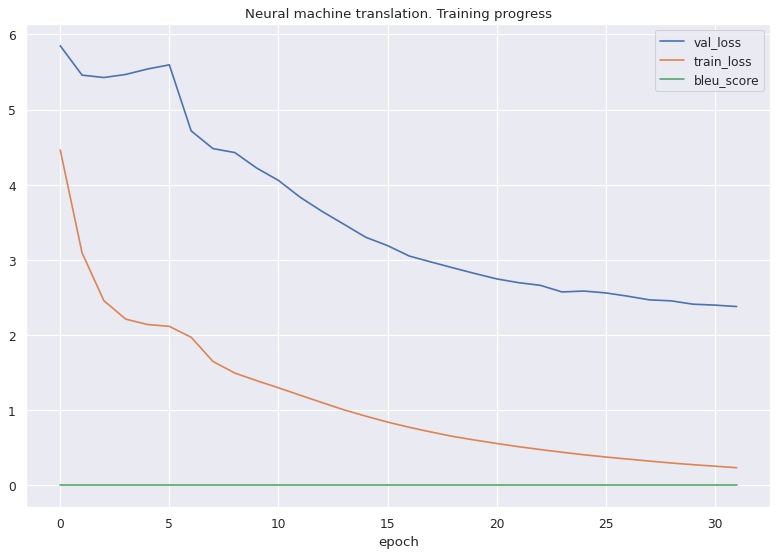

In [16]:
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
import ast

with open("./baseline/progress_log.txt", 'r') as fread:
    stats = fread.readlines()
sns.lineplot
val_loss, train_loss, bleu_score = [], [], []
for i in range(1, len(stats)):
    stats[i] = ast.literal_eval(stats[i])
    val_loss.append(stats[i]['val_loss'])
    train_loss.append(stats[i]['train_loss'])
    bleu_score.append(stats[i]['bleu_score'])

sns.set_theme()
plt.figure(figsize=(12, 8), dpi=80)
sns.lineplot(np.arange(len(val_loss)), val_loss, label='val_loss')
sns.lineplot(np.arange(len(train_loss)), train_loss, label='train_loss')
sns.lineplot(np.arange(len(bleu_score)), bleu_score, label='bleu_score')
plt.xlabel('epoch')
plt.title('Neural machine translation. Training progress')
plt.legend();

#### Графики обучения и валидации выходят на плато. Переобучение модели

## generate examples of translation

In [22]:
batch = next(iter(val_dataloader))
inp, tgt = batch[0][:10], batch[1][:10]
model.eval()
with torch.no_grad():
    out = model.generate(inp)

for i in range(10):
    src_decoded = " ".join(data_manager.source_tokenizer.decode(inp[i].cpu().numpy().tolist()))
    out_decoded = " ".join(data_manager.target_tokenizer.decode(out[i].cpu().numpy().tolist()))
    tgt_decoded = " ".join(data_manager.target_tokenizer.decode(tgt[i].cpu().numpy().tolist()))
    print(f"EN: {src_decoded}\nRU: {tgt_decoded}\nPRED: {out_decoded}")
    print('>>>>>>>>>')

EN: he is an individual with his own living sp ac e and his own sleeping
RU: он су ще ство с собствен ным жиз н ен ным про стра н ством
PRED: младшая рада тянет старикам только школу большой навестит умна убьёт супермодель моего наго прячется плане
>>>>>>>>>
EN: he s not always at home on sundays
RU: он не всегда дома по воскресеньям
PRED: правду ужасном большой деревни смелая нехороший автобуса дышать сыном сыном здесь юм вось ней ней
>>>>>>>>>
EN: she s busy now and can t speak to you
RU: она сейчас занята и не может с вами разговаривать
PRED: работы школу нём школу школу тот старой больна говорит образованная футболист щедр меня меня меня
>>>>>>>>>
EN: he is saving money for a trip abroad
RU: он от кла дывает деньги на поез д ку за границу
PRED: убьёт практики того того того дю школу я я я под под под брюзга пожалеет
>>>>>>>>>
EN: he is content with his present state
RU: его у стра и вает его те ку ще е поло жен ие
PRED: свободно истеричная делает отеле шкафу взглядов храбрый плохое

### Fine-tune pretrained T5 (25 баллов)

Реализуйте Seq2seq Pretrained T5. Воспользуйтесь https://huggingface.co/docs/transformers/model_doc/t5 предобученной моделью. В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов. Архитектура модели(количетсво слоев, размерность и тд) остается на ваш выбор.

Не забудьте важные аспекты обучения модели:
* Взять готовый t5 токенизатор
* Resize matrix embedding - скорей всего ваша матрица эмбеддингов не будет включать эмбеддинги из вашего сета. Пример обновления матрицы эмбеддингов тут тут https://github.com/runnerup96/Transformers-Tuning/blob/main/t5_encoder_decoder.py
* Learning rate schedualer/Adafactor with constant learning rate


В качестве результатов, приложите слудующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, pretrained model name
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

In [5]:
import sys
sys.path.insert(0, '/ssd/r.musaev/DL_sber_hw/pytorch-machine-translation/src')

In [44]:
import torch
import numpy as np
import random
import torch.nn as nn
import yaml
from src.data.datamodule import DataManager
from src.txt_logger import TXTLogger
%reload_ext autoreload
%autoreload 2
from src.models.seq2seq_t5 import Seq2SeqT5
from src.models import trainer

In [45]:
def seed_everything(seed: int):    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger = TXTLogger("baseline_t5")


In [46]:
with open("configs/t5_data_config.yaml", "r") as fread:
    data_config = yaml.load(fread, Loader=yaml.Loader)

data_manager = DataManager(data_config, device)
train_dataloader, val_dataloader = data_manager.prepare_data()

Reading from file: 100%|██████████| 467119/467119 [00:07<00:00, 62105.40it/s]


In [47]:
with open("configs/t5_model_config.yaml", "r") as fread:
    model_config = yaml.load(fread, Loader=yaml.Loader)

model_config["device"] = device 
model_config["tokenizer_length"] = data_config["tokenizer_length"]
model = Seq2SeqT5(model_config).to(device)

In [48]:
model_config

{'embedding_size': 100,
 'hidden_size': 100,
 'epoch_num': 100,
 'lr': 0.0003,
 'maxlen': 15,
 'device': device(type='cuda'),
 'tokenizer_length': 32100}

In [49]:
trainer_cls = trainer.Trainer(
    model=model,
    model_config=model_config,
    logger=logger,
    target_tokenizer=data_config["tokenizer"]
    )

trainer_cls.train(train_dataloader, val_dataloader)

 22%|██▏       | 22/100 [04:00<14:12, 10.93s/it]

Last 22 epoch train loss:  23.37715482711792
Last 22 epoch val loss:  1.5177882313728333
Last 22 epoch val bleu:  0.0


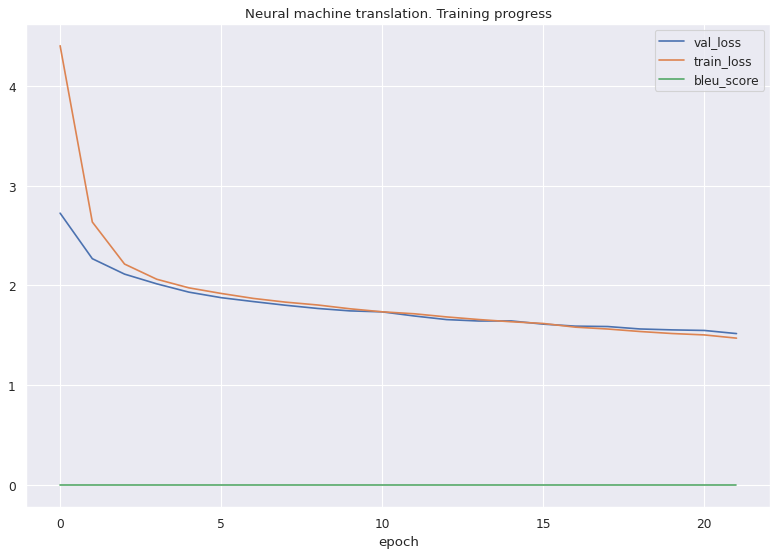

In [50]:
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
import ast

with open("./baseline_t5/progress_log.txt", 'r') as fread:
    stats = fread.readlines()
sns.lineplot
val_loss, train_loss, bleu_score = [], [], []
for i in range(1, len(stats)):
    stats[i] = ast.literal_eval(stats[i])
    val_loss.append(stats[i]['val_loss'])
    train_loss.append(stats[i]['train_loss'])
    bleu_score.append(stats[i]['bleu_score'])

sns.set_theme()
plt.figure(figsize=(12, 8), dpi=80)
sns.lineplot(np.arange(len(val_loss)), val_loss, label='val_loss')
sns.lineplot(np.arange(len(train_loss)), train_loss, label='train_loss')
sns.lineplot(np.arange(len(bleu_score)), bleu_score, label='bleu_score')
plt.xlabel('epoch')
plt.title('Neural machine translation. Training progress')
plt.legend();

In [51]:
batch = next(iter(val_dataloader))
inp, tgt = batch[0][:10], batch[1][:10]
model.eval()
with torch.no_grad():
    out = model.generate(inp)

for i in range(10):
    src_decoded = " ".join(data_manager.source_tokenizer.decode(inp[i].cpu().numpy().tolist()))
    out_decoded = " ".join(data_manager.target_tokenizer.decode(out[i].cpu().numpy().tolist()))
    tgt_decoded = " ".join(data_manager.target_tokenizer.decode(tgt[i].cpu().numpy().tolist()))
    print(f"EN: {src_decoded}\nRU: {tgt_decoded}\nPRED: {out_decoded}")
    print('>>>>>>>>>')

EN: h e   i s   t r y i n g   t o   s t u d y   a s   h a r d   a s   h e   c a n < / s > < p a d > < p a d >
RU: о н   < u n k >   т а е т с < u n k >   у < u n k >   и т < u n k >   с < / s >
PRED: < p a d >   о н   < u n k >   о р о < u n k >   о   < u n k >   о р о < u n k >   о < / s > < p a d > < p a d > < p a d > < p a d >
>>>>>>>>>
EN: s h e   i s   n o   l e s s   b e a u t i f u l   t h a n   h e r   s i s t e r   i s < / s > < p a d > < p a d > < p a d > < p a d > < p a d >
RU: о н а   н е   м е н е е   к р а с и в а < / s >
PRED: < p a d >   о н а   н е   < u n k >   о л < u n k >   о < u n k >   < u n k >   е < / s > < p a d > < p a d > < p a d > < p a d >
>>>>>>>>>
EN: h e   i s   t h e   b l a c k   s h e e p   o f   t h e   f a m i l y < / s > < p a d > < p a d > < p a d > < p a d > < p a d >
RU: о н   < u n k >   а р < u n k >   и в а < u n k >   о в < u n k >   а < / s >
PRED: < p a d >   о н   < u n k >   о р о < u n k >   о   < u n k >   о < u n k >   и < u n k > < 